# Features and Model

For Study about DS_technical_test_tutorial

This notebook shows : 
- features preparation
- models training  and testing in order to classify housing assistance requests thanks to the given datasets.

- This is a multi-class classification task

- The metric to optimize and the datasets description are explained in DS_technical_test_tutorial.ipynb Jupyter Notebook.

## import

In [592]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)

# HELPERS
import time
import datetime
import re
# DATA
import numpy as np
import pandas as pd
import json

#SCIKIT LEARN
from sklearn.metrics import accuracy_score, log_loss, make_scorer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import model_selection
from sklearn import preprocessing

from joblib import dump, load

## Definitions

In [658]:
# path OUTPUT DATA 
PATH_DATA = 'data'
# data cleaned
PATH_REQ_TRAIN_CLEAN = PATH_DATA + '/requests_train_clean.csv'
PATH_REQ_TEST_CLEAN = PATH_DATA + '/requests_test_clean.csv'

# Features
PATH_FS1_LIST = PATH_DATA +  '/fs1_list.json'
PATH_FS1_TRAIN = PATH_DATA + '/fs1_train.csv'
PATH_FS1_TEST = PATH_DATA +  '/fs1_test.csv'

# dataFrame scores
df_results=None


## Useful functions

In [609]:
# Define the test scorer
def competition_scorer(y_true, y_pred):
    return log_loss(y_true, y_pred, sample_weight=10**y_true)


def display_missing(df):
    '''
    Function to display missing values into dataframe.
    Creates a barplots figure and outputs values.

    - input : 
        df : dataframe : data to check
    - output : 
        df_missing : dataframe : table of missing values
    '''
    nb_lignes = df.shape[0]
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    df_missing = nb_missing.to_frame()
    df_missing.rename(index=str, columns={0: "nb_missing"}, inplace=True)
    df_missing["ratio"] = 100*df_missing["nb_missing"] / nb_lignes
    fig = plt.figure(figsize=(7, 7))
    liste_name_bars = df_missing.index.values
    liste_name_bars_num = []
    for name in liste_name_bars:
        liste_name_bars_num.append("{} [{}]".format(
            name, df_missing.loc[name, "nb_missing"]))
    ax = sns.barplot(y=liste_name_bars_num, x='ratio', data=df_missing)
    plt.title('Missing lines Ratio over {} lines'.format(nb_lignes))
    ax.set(xlabel='repartition [%]')
    ax.set_xlim([0, 100])
    return df_missing


def plot_hist_cat(x, data, title):
    '''
    Plot histogram count of categorical data 
    Add proportional information
    '''
    ser_val = data[x].value_counts(dropna=False)
    pc_val = ser_val.values / data[x].shape[0]

    sns.catplot(x=x, kind="count", palette="ch:.25", data=data, 
                height=7, 
                aspect=1.7,
                order=ser_val.index)
    fig = plt.gcf()
    ax = fig.gca()

    for K, y_val in enumerate(ser_val.values):
        ax.text(K, y_val, '{:.2f}'.format(pc_val[K]))
    
    ax.set_title(title)
    
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    
def plot_cont(X,Y,data):
    '''
    Calculate Chi-2 heatmap into contingency table for 
    X event and Y event
    '''
    c = data[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len)
    cont = c.copy()

    tx = data[X].value_counts()
    ty = data[Y].value_counts()

    cont.loc[:,"Total"] = tx
    cont.loc["total",:] = ty
    cont.loc["total","Total"] = len(data)
    cont

    tx = pd.DataFrame(tx)
    ty = pd.DataFrame(ty)
    tx.columns = ["foo"]
    ty.columns = ["foo"]
    n = len(data)
    indep = tx.dot(ty.T) / n

    c = c.fillna(0) # on remplace les valeurs nulles par des 0
    mesure = (c-indep)**2/indep
    xi_n = mesure.sum().sum()
    # plot
    fig = plt.figure(figsize = (5,11.75))
    sns.heatmap(mesure/xi_n, annot=c, fmt=".0f")
    plt.show()
    
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues, size=16, fontsize=12, 
                          threshold=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    source : 
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]

    # extract most important confusion if threshold
    if threshold is not None:
      list_idx=[]
      for i in range(0, cm.shape[0]):
        for j in range(0, cm.shape[1]):
          if i != j:
            if cm[i,j] > threshold:
              list_idx.append(i)
              list_idx.append(j)
      list_idx = np.unique(list_idx)
      cm = cm[np.ix_(list_idx, list_idx)]
      classes = classes[list_idx]

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
 
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor", fontsize=fontsize)
    # resize y tick labels
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=fontsize,
                    fontweight="black" if i==j else "normal")
    fig.tight_layout()

    fig.set_size_inches([size,size])
    ax.set_ylim([cm.shape[1]-0.5,-0.5]);
    ax.grid(linewidth=0)
    return ax

def plot_res_test_split(myDf, myScore, myX, myHue=None, y_min=None,
                       myFixedParam=None, myFixedValue=None, cv_eval=None):
    '''
    Create multiple batplot to compare scorings result over gridsearchcv for 
    Test splits
    - Add errorbar
    - choice for x axis & hue.
    
    example: 
        plot_res_test_split(df_res_rf_multi_cv, "accuracy", "param_max_depth", 
                            "param_min_samples_split",
                            y_min=0.15, 
                            myFixedParam="param_n_estimators",
                            myFixedValue=25)
    '''
    
    def plot_max_value():
        '''
        errorbar min plot
        '''
        return sns.barplot(hue=myHue, 
                y="mean_test_" + myScore + "_max",
                x=myX,
                data=df_cv_temp,
                 alpha=0.5)
    
    def plot_value():
        '''
        normal plot
        '''
        return sns.barplot(hue=myHue, 
            y="mean_test_" + myScore,
            x=myX,
            data=df_cv_temp, ci='sd')
            
    def plot_min_value():
        '''
        errorbar min plot
        '''
        return sns.barplot(hue=myHue, 
                y="mean_test_" + myScore + "_min",
                x=myX,
                data=df_cv_temp,
                 alpha=0.5)       
        
    if cv_eval is None:
        cv_eval = cv
        
    if myFixedParam is None:
        str_add_for_title=""
    else:
        str_add_for_title=" for " + myFixedParam + "={}".format(myFixedValue)
        
    myTitle = myScore + " on Test splits [%]" + str_add_for_title
    fig = plt.figure(figsize=(15, 8.5))
    plt.title(myTitle)
    
    # work on data
    df_cv_temp = myDf.copy()
    # correct data by zeros value if None:
    df_cv_temp.loc[df_cv_temp[myX].isna(), myX] = 0
    if myHue is not None:
        df_cv_temp.loc[df_cv_temp[myHue].isna(), myHue] = 0
    if myFixedParam is not None:
        df_cv_temp.loc[df_cv_temp[myFixedParam].isna(), myFixedParam] = 0
    # select data : if Fixed Param
    if myFixedParam is not None:
        df_cv_temp = df_cv_temp[df_cv_temp[myFixedParam] == myFixedValue]
    
    # errorbar max : Xmax = X + 1.96 * STD(X) / sqrt(n_samples)
    df_cv_temp["mean_test_" + myScore +"_max"] = \
        df_cv_temp["mean_test_" + myScore] + \
        1.96*df_cv_temp["std_test_" + myScore]/math.sqrt(cv_eval.n_splits)  

    # errorbar min : Xmin = X - 1.96 * STD(X) / sqrt(n_samples)
    df_cv_temp["mean_test_" + myScore + "_min"] = \
        df_cv_temp["mean_test_" + myScore] - \
        1.96*df_cv_temp["std_test_" + myScore]/math.sqrt(cv_eval.n_splits)
    
    # plots by order to show all min/normal/max values on barplot
    if df_cv_temp["mean_test_" + myScore].max() > 0:
        # errorbar max plot
        ax2 = plot_max_value()
        # normal plot
        ax = plot_value()
        # errorbar min plot
        ax3 = plot_min_value()
    else:
        # errorbar min plot
        ax3 = plot_min_value()
        # normal plot
        ax = plot_value()
        # errorbar max plot
        ax2 = plot_max_value()
        
    # correct ylabel 
    ax.set_ylabel("mean_test_" + myScore)
    
    # correct plot size
    nb_x_plot = df_cv_temp[myX].nunique()
    ax.set_xlim(right=nb_x_plot+1.5)
    if y_min is not None:
        if y_min >= 0:
            ax.set_ylim(bottom=y_min)
        else:
            ax.set_ylim(top=y_min)
    
    # correct legend
    if myHue is not None:
        leg = ax.get_legend()
        leg_title = leg.get_title().get_text()
        leg.remove()
        h,l = ax.get_legend_handles_labels()
        nb_leg_max = df_cv_temp[myHue].nunique()
        plt.legend(h[nb_leg_max:nb_leg_max*2], 
                   l[nb_leg_max:nb_leg_max*2], title=leg_title);
        
    # add maximum line
    plt.plot([-0.5, nb_x_plot], 
         np.array([1,1])*df_cv_temp["mean_test_" + myScore].max(),'r--')
    plt.text(nb_x_plot, df_cv_temp["mean_test_" + myScore].max(),
         "{:.4f}".format(df_cv_temp["mean_test_" + myScore].max()),
             fontsize=14, color="r")

    return ax, fig

def add_score(df_results, series_scores, model_name):
    """
    Add score line into dataFrame of models scores
    
    series_scores : dictionnary : ex :  {mean_test_acc: 0.5, ...}
    """
    df_results_add = pd.DataFrame(data=series_scores, columns=[model_name]).T
    
    if df_results is None: # create table
        print('create df_results')
        df_results = df_results_add.copy()
    else: # update or add line
        try:
            # ligne existe alors on efface l'ancienne ligne  ?
            df_results = df_results.drop(index=model_name)                                
            print('update line')
        except:
            # n'existe pas
            print('add line')
            
        # on ajoute la ligne
        df_results = df_results.append(df_results_add)
        
    return df_results

## Load data

In [4]:
requests_train = pd.read_csv(filepath_or_buffer=PATH_REQ_TRAIN_CLEAN,
                             sep=',',
                             low_memory=False,
                             error_bad_lines=False)

requests_test = pd.read_csv(filepath_or_buffer=PATH_REQ_TEST_CLEAN,
                            sep=',',
                            low_memory=False,
                            error_bad_lines=False)


requests_train.head()

,request_id,animal_presence,answer_creation_date,child_situation,child_to_come,district,granted_number_of_nights,group_composition_id,group_composition_label,group_creation_date,...,age_mean,disabled_worker_certification,nb_female,nb_male,married,request_creation_date_fmt,request_creation_day,request_creation_day_num,request_creation_month,child_situation_red
0,130667d2964de43c511d0ead7ac66b33,f,2019-02-11 22:30:00,-1,unknown,85,1,10,man alone,2018-05-03 12:10:40.416,...,42.0,f,0.0,1.0,f,2019-02-11 22:30:00,Mon,1,2,0
1,b1cd62fcf24eebb0f685d5eaf55317a8,f,2019-02-12 09:00:00,-1,unknown,85,1,10,man alone,2019-03-07 12:11:08.545,...,39.0,f,0.0,1.0,f,2019-02-12 09:00:00,Tue,2,2,0
2,12cc0a18890bd4959fe42df3ae58838e,f,2019-02-01 21:00:00,-1,unknown,59,1,80,isolated child/underage,2019-03-13 12:54:15.887,...,16.0,f,0.0,1.0,f,2019-02-01 21:00:00,Fri,5,2,0
3,ae2d5b4dc181d29e430132f145da1556,f,2019-02-25 15:12:05.037,-1,unknown,50,2,20,woman alone,2018-10-09 14:37:29.773,...,33.0,f,1.0,0.0,f,2019-02-25 15:12:05,Mon,1,2,0
4,d13a17ce36c832514fda2464e11c4a9f,f,2019-02-20 09:59:20.603,-1,unknown,93,2,60,group with child(ren),2018-10-02 10:47:36.931,...,32.0,f,2.0,1.0,f,2019-02-20 09:59:20,Wed,3,2,0


In [5]:
requests_train.shape

(238191, 41)

In [6]:
requests_test.shape

(59548, 41)

In [7]:
requests_train_raw = pd.read_csv(filepath_or_buffer='data/requests_train.csv',
                             sep=',',
                             low_memory=False,
                             error_bad_lines=False)

requests_test_raw = pd.read_csv(filepath_or_buffer='data/requests_test.csv',
                            sep=',',
                            low_memory=False,
                            error_bad_lines=False)

In [8]:
requests_train_raw.shape

(238191, 24)

In [9]:
requests_test_raw.shape

(59548, 24)

## Features selection

### FS1

Only one Features selection have been done to reach the score.

Can be improve be reducing dimension by reduce number of classes for some categorical features

It is possible also to use PCA decomposition (not done here)

Take all possible features : 

In [10]:
requests_train.columns.tolist()

['request_id',
 'animal_presence',
 'answer_creation_date',
 'child_situation',
 'child_to_come',
 'district',
 'granted_number_of_nights',
 'group_composition_id',
 'group_composition_label',
 'group_creation_date',
 'group_id',
 'group_main_requester_id',
 'group_type',
 'housing_situation_id',
 'housing_situation_label',
 'long_term_housing_request',
 'number_of_underage',
 'request_backoffice_creator_id',
 'request_creation_date',
 'requester_type',
 'social_situation_id',
 'town',
 'victim_of_violence',
 'victim_of_violence_type',
 'housing_situation_2_label',
 'pregnancy',
 'region',
 'childcare_center_supervision',
 'nb_underage_red',
 'age_max',
 'age_min',
 'age_mean',
 'disabled_worker_certification',
 'nb_female',
 'nb_male',
 'married',
 'request_creation_date_fmt',
 'request_creation_day',
 'request_creation_day_num',
 'request_creation_month',
 'child_situation_red']

We need to one hot encode all categorical features, execept ordinal cat, bol, int

In [11]:
list_filter_raw = ['granted_number_of_nights', # int
                'animal_presence', # bol
                'group_composition_label', # cat 
                'housing_situation_label', # cat (#)
                'long_term_housing_request', # cat (3)
                'requester_type', # cat (3)
                'victim_of_violence_type', # cat
                'pregnancy', # bol
                'region', # cat
                'childcare_center_supervision', # bol
                'nb_underage_red', # int
                'age_min', # int
                'age_max', # int
                'disabled_worker_certification', # bol
                'nb_female', # int
                'nb_male', # int
                'married', # bol
                'request_creation_day_num', # ordinal cat int
                'request_creation_month',  # ordinal cat int
                'child_situation_red'] # bol 

# feature ready 
list_feat = ['nb_underage_red', 
             'age_min', 
             'age_max', 
             'nb_female',
             'nb_male',
             'request_creation_day_num',
             'request_creation_month',
             'child_situation_red']

In [12]:
df_train = requests_train.filter(items=list_filter_raw)
df_test = requests_test.filter(items=list_filter_raw)
df_train.head()

,granted_number_of_nights,animal_presence,group_composition_label,housing_situation_label,long_term_housing_request,requester_type,victim_of_violence_type,pregnancy,region,childcare_center_supervision,nb_underage_red,age_min,age_max,disabled_worker_certification,nb_female,nb_male,married,request_creation_day_num,request_creation_month,child_situation_red
0,1,f,man alone,street,unknown,third party,f,f,Provence-Alpes-Côte d'Azur,f,0,42.0,42.0,f,0.0,1.0,f,1,2,0
1,1,f,man alone,street,unknown,user,f,f,Provence-Alpes-Côte d'Azur,f,0,39.0,39.0,f,0.0,1.0,f,2,2,0
2,1,f,isolated child/underage,street,unknown,user,f,f,Grand Est,f,0,16.0,16.0,f,0.0,1.0,f,5,2,0
3,2,f,woman alone,street,unknown,user,woman,f,Bretagne,f,0,33.0,33.0,f,1.0,0.0,f,1,2,0
4,2,f,group with child(ren),hotel paid by the emergency centre,unknown,user,f,f,Île-de-France,f,0,17.0,40.0,f,2.0,1.0,f,3,2,0


#### animal_presence : str -> bol

In [13]:
def fun_str_to_bol(str_in):
    if str_in == 't':
        return 1
    else:
        return 0


df_train['animal_presence_bol'] = \
    df_train['animal_presence'].apply(fun_str_to_bol)
df_test['animal_presence_bol'] = \
    df_test['animal_presence'].apply(fun_str_to_bol)

list_feat.append('animal_presence_bol')

#### group_composition_label : one hot encoding

In [14]:
df_add = pd.get_dummies(df_train["group_composition_label"], 
               prefix='gcl', drop_first=True)
list_feat = list_feat +  df_add.columns.tolist()

In [15]:
df_tmp = pd.concat([df_train, df_add], axis=1)

In [16]:
df_train.shape

(238191, 21)

In [17]:
df_tmp.shape

(238191, 32)

In [18]:
df_train = df_tmp.copy()

In [19]:
df_train.head()

,granted_number_of_nights,animal_presence,group_composition_label,housing_situation_label,long_term_housing_request,requester_type,victim_of_violence_type,pregnancy,region,childcare_center_supervision,...,gcl_couple with child(ren),gcl_couple without whildren,gcl_group of adults,gcl_group with child(ren),gcl_isolated child/underage,gcl_man alone,gcl_single father with child(ren),gcl_single mother with child(ren),gcl_woman alone,gcl_women victim of violence
0,1,f,man alone,street,unknown,third party,f,f,Provence-Alpes-Côte d'Azur,f,...,0,0,0,0,0,1,0,0,0,0
1,1,f,man alone,street,unknown,user,f,f,Provence-Alpes-Côte d'Azur,f,...,0,0,0,0,0,1,0,0,0,0
2,1,f,isolated child/underage,street,unknown,user,f,f,Grand Est,f,...,0,0,0,0,1,0,0,0,0,0
3,2,f,woman alone,street,unknown,user,woman,f,Bretagne,f,...,0,0,0,0,0,0,0,0,1,0
4,2,f,group with child(ren),hotel paid by the emergency centre,unknown,user,f,f,Île-de-France,f,...,0,0,0,1,0,0,0,0,0,0


In [20]:
df_test = pd.concat([df_test, 
          pd.get_dummies(df_test["group_composition_label"], 
               prefix='gcl', drop_first=True)], axis=1)

In [21]:
df_test.shape

(59548, 32)

#### housing_situation_label : one hot encoding

In [22]:
df_add = pd.get_dummies(df_train["housing_situation_label"], 
               prefix='hs', drop_first=True)
list_feat = list_feat +  df_add.columns.tolist()

In [23]:
df_add

,hs_detoxification center,hs_emergency structure,hs_hotel paid by an association,hs_hotel paid by the emergency centre,hs_hotel paid by the household,hs_hotel paid by the regional administration,hs_inclusion structure,hs_mobile or makeshift shelter,hs_other,hs_parental home,hs_personal or marital home,hs_police station,hs_prison,hs_psychiatric hospital,hs_public hospital,hs_refused to answer,"hs_religious place (church, mosque, synogogue)",hs_shelters,hs_stabilisation structure,hs_street
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238186,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
238187,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
238188,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
238189,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
df_tmp = pd.concat([df_train, df_add], axis=1)

In [25]:
df_train.shape

(238191, 32)

In [26]:
df_tmp.shape

(238191, 52)

In [27]:
df_train = df_tmp.copy()

In [28]:
df_train["housing_situation_label"].nunique()

21

In [29]:
df_test["housing_situation_label"].nunique()

21

In [30]:
df_test = pd.concat([df_test, 
          pd.get_dummies(df_test["housing_situation_label"], 
               prefix='hs', drop_first=True)], axis=1)

In [31]:
df_test.shape

(59548, 52)

#### long_term_housing_request : one hot encoding

We replace unknown by NaN

In [32]:
df_train["long_term_housing_request"].value_counts()

unknown    165556
f           60386
t           12249
Name: long_term_housing_request, dtype: int64

In [33]:
df_train.loc[df_train["long_term_housing_request"] == "unknown", 
   "long_term_housing_request"] = np.nan

In [34]:
df_train["long_term_housing_request"].value_counts(dropna=False)

NaN    165556
f       60386
t       12249
Name: long_term_housing_request, dtype: int64

In [35]:
df_add = pd.get_dummies(df_train["long_term_housing_request"], 
               prefix='lts_req')
df_add

,lts_req_f,lts_req_t
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
238186,1,0
238187,0,0
238188,0,0
238189,1,0


In [36]:
list_feat = list_feat +  df_add.columns.tolist()

In [37]:
df_tmp = pd.concat([df_train, df_add], axis=1)

In [38]:
df_train.shape

(238191, 52)

In [39]:
df_tmp.shape

(238191, 54)

In [40]:
df_train = df_tmp.copy()

In [41]:
df_train.sample(5)

,granted_number_of_nights,animal_presence,group_composition_label,housing_situation_label,long_term_housing_request,requester_type,victim_of_violence_type,pregnancy,region,childcare_center_supervision,...,hs_prison,hs_psychiatric hospital,hs_public hospital,hs_refused to answer,"hs_religious place (church, mosque, synogogue)",hs_shelters,hs_stabilisation structure,hs_street,lts_req_f,lts_req_t
45046,0,f,man alone,street,f,user,f,f,Hauts-de-France,f,...,0,0,0,0,0,0,0,1,1,0
79973,2,f,woman alone,accomodation by a third party,NaN,user,f,f,Hauts-de-France,f,...,0,0,0,0,0,0,0,0,0,0
200132,2,f,group of adults,street,t,user,f,f,Île-de-France,f,...,0,0,0,0,0,0,0,1,0,1
39414,1,f,man alone,emergency structure,f,user,f,f,Auvergne-Rhône-Alpes,f,...,0,0,0,0,0,0,0,0,1,0
15860,1,f,couple without whildren,accomodation by a third party,NaN,user,unknown,f,Centre-Val de Loire,f,...,0,0,0,0,0,0,0,0,0,0


In [42]:
df_test.loc[df_test["long_term_housing_request"] == "unknown", 
   "long_term_housing_request"] = np.nan

In [43]:
df_test = pd.concat([df_test, 
          pd.get_dummies(df_test["long_term_housing_request"], 
               prefix='lts_req')], axis=1)

In [44]:
df_test

,granted_number_of_nights,animal_presence,group_composition_label,housing_situation_label,long_term_housing_request,requester_type,victim_of_violence_type,pregnancy,region,childcare_center_supervision,...,hs_prison,hs_psychiatric hospital,hs_public hospital,hs_refused to answer,"hs_religious place (church, mosque, synogogue)",hs_shelters,hs_stabilisation structure,hs_street,lts_req_f,lts_req_t
0,0,f,single mother with child(ren),street,NaN,user,f,f,Hauts-de-France,f,...,0,0,0,0,0,0,0,1,0,0
1,0,f,man alone,street,NaN,user,f,f,Auvergne-Rhône-Alpes,f,...,0,0,0,0,0,0,0,1,0,0
2,0,f,woman alone,public hospital,f,user,f,f,Occitanie,f,...,0,0,1,0,0,0,0,0,1,0
3,0,f,man alone,street,NaN,user,f,f,Île-de-France,f,...,0,0,0,0,0,0,0,1,0,0
4,0,f,man alone,street,NaN,user,f,f,Provence-Alpes-Côte d'Azur,f,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59543,1,f,couple with child(ren),emergency structure,NaN,user,f,f,Nouvelle-Aquitaine,f,...,0,0,0,0,0,0,0,0,0,0
59544,1,f,single mother with child(ren),emergency structure,NaN,user,f,f,Pays de la Loire,f,...,0,0,0,0,0,0,0,0,0,0
59545,2,f,man alone,emergency structure,NaN,user,f,f,Île-de-France,f,...,0,0,0,0,0,0,0,0,0,0
59546,1,f,single mother with child(ren),accomodation by a third party,NaN,user,f,f,Île-de-France,f,...,0,0,0,0,0,0,0,0,0,0


In [45]:
df_test.shape

(59548, 54)

#### requester_type : one hot encoding

In [46]:
df_add = pd.get_dummies(df_train["requester_type"], 
               prefix='rt', drop_first=True)
list_feat = list_feat +  df_add.columns.tolist()

In [47]:
df_add

,rt_third party,rt_user
0,1,0
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
238186,0,1
238187,0,1
238188,0,1
238189,0,1


In [48]:
df_tmp = pd.concat([df_train, df_add], axis=1)

In [49]:
df_train.shape

(238191, 54)

In [50]:
df_tmp.shape

(238191, 56)

In [51]:
df_train = df_tmp.copy()

In [52]:
df_train.head()

,granted_number_of_nights,animal_presence,group_composition_label,housing_situation_label,long_term_housing_request,requester_type,victim_of_violence_type,pregnancy,region,childcare_center_supervision,...,hs_public hospital,hs_refused to answer,"hs_religious place (church, mosque, synogogue)",hs_shelters,hs_stabilisation structure,hs_street,lts_req_f,lts_req_t,rt_third party,rt_user
0,1,f,man alone,street,NaN,third party,f,f,Provence-Alpes-Côte d'Azur,f,...,0,0,0,0,0,1,0,0,1,0
1,1,f,man alone,street,NaN,user,f,f,Provence-Alpes-Côte d'Azur,f,...,0,0,0,0,0,1,0,0,0,1
2,1,f,isolated child/underage,street,NaN,user,f,f,Grand Est,f,...,0,0,0,0,0,1,0,0,0,1
3,2,f,woman alone,street,NaN,user,woman,f,Bretagne,f,...,0,0,0,0,0,1,0,0,0,1
4,2,f,group with child(ren),hotel paid by the emergency centre,NaN,user,f,f,Île-de-France,f,...,0,0,0,0,0,0,0,0,0,1


In [53]:
df_test = pd.concat([df_test, 
          pd.get_dummies(df_test["requester_type"], 
               prefix='rt', drop_first=True)], axis=1)

In [54]:
df_test.shape

(59548, 56)

#### victim_of_violence_type

In [55]:
df_train.loc[df_train["victim_of_violence_type"] == "f", 
   "victim_of_violence_type"] = np.nan

In [56]:
df_train["victim_of_violence_type"].nunique()

7

In [57]:
df_test.loc[df_test["victim_of_violence_type"] == "f", 
   "victim_of_violence_type"] = np.nan

In [58]:
df_test["victim_of_violence_type"].nunique()

7

In [59]:
df_add = pd.get_dummies(df_train["victim_of_violence_type"], 
               prefix='vvt')
df_add

,vvt_child,vvt_family,vvt_man,vvt_man victim of domestic violence,vvt_unknown,vvt_woman,vvt_woman victim of domestic violence
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
238186,0,0,0,0,0,0,0
238187,0,0,0,0,0,0,0
238188,0,0,0,0,0,0,0
238189,0,0,0,0,0,0,0


In [60]:
list_feat = list_feat +  df_add.columns.tolist()

In [61]:
df_tmp = pd.concat([df_train, df_add], axis=1)

In [62]:
df_train.shape

(238191, 56)

In [63]:
df_tmp.shape

(238191, 63)

In [64]:
df_train = df_tmp.copy()

In [65]:
df_test = pd.concat([df_test, 
          pd.get_dummies(df_test["victim_of_violence_type"], 
               prefix='vvt')], axis=1)

In [66]:
df_test.shape

(59548, 63)

#### pregnancy

In [67]:
df_train['pregnancy_bol'] = \
    df_train['pregnancy'].apply(fun_str_to_bol)
df_test['pregnancy_bol'] = \
    df_test['pregnancy'].apply(fun_str_to_bol)

list_feat.append('pregnancy_bol')

In [68]:
df_train.shape

(238191, 64)

In [69]:
df_test.shape

(59548, 64)

#### region : one hot encoding

In [70]:
df_train.loc[df_train["region"] == "unknown", "region"] = np.nan

In [71]:
df_test.loc[df_test["region"] == "unknown", "region"] = np.nan

In [72]:
df_train["region"].nunique()

16

In [73]:
df_test["region"].nunique()

14

In [74]:
df_add = pd.get_dummies(df_train["region"], 
               prefix='reg')
df_add

,reg_Auvergne-Rhône-Alpes,reg_Bourgogne-Franche-Comté,reg_Bretagne,reg_Centre-Val de Loire,reg_Corse,reg_Grand Est,reg_Guadeloupe,reg_Guyane,reg_Hauts-de-France,reg_Martinique,reg_Normandie,reg_Nouvelle-Aquitaine,reg_Occitanie,reg_Pays de la Loire,reg_Provence-Alpes-Côte d'Azur,reg_Île-de-France
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238186,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
238187,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
238188,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
238189,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [75]:
list_region = df_add.columns.tolist()
list_feat = list_feat +  list_region

In [76]:
df_tmp = pd.concat([df_train, df_add], axis=1)

In [77]:
df_train.shape

(238191, 64)

In [78]:
df_tmp.shape

(238191, 80)

In [79]:
df_train = df_tmp.copy()

For test : we have to give 16 regions

In [80]:
list_reg = df_train["region"].unique().tolist()
list_reg = [elem for elem in list_reg if elem is not np.nan]
list_reg

["Provence-Alpes-Côte d'Azur",
 'Grand Est',
 'Bretagne',
 'Île-de-France',
 'Pays de la Loire',
 'Auvergne-Rhône-Alpes',
 'Hauts-de-France',
 'Normandie',
 'Nouvelle-Aquitaine',
 'Bourgogne-Franche-Comté',
 'Occitanie',
 'Centre-Val de Loire',
 'Guyane',
 'Martinique',
 'Guadeloupe',
 'Corse']

In [81]:
len(list_reg)

16

In [82]:
df_tmp = df_test.copy()

df_tmp["region"] = pd.Categorical(df_tmp["region"],
                                    categories=list_reg)
df_add = pd.get_dummies(df_tmp["region"], prefix='reg')

In [83]:
df_add

,reg_Provence-Alpes-Côte d'Azur,reg_Grand Est,reg_Bretagne,reg_Île-de-France,reg_Pays de la Loire,reg_Auvergne-Rhône-Alpes,reg_Hauts-de-France,reg_Normandie,reg_Nouvelle-Aquitaine,reg_Bourgogne-Franche-Comté,reg_Occitanie,reg_Centre-Val de Loire,reg_Guyane,reg_Martinique,reg_Guadeloupe,reg_Corse
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59543,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
59544,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
59545,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
59546,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [84]:
df_add.shape

(59548, 16)

In [85]:
df_tmp = pd.concat([df_test, df_add], axis=1)

In [86]:
df_test.shape

(59548, 64)

In [87]:
df_tmp.shape

(59548, 80)

In [88]:
df_test = df_tmp.copy()

#### childcare_center_supervision

In [89]:
df_train['childcare_center_supervision_bol'] = \
    df_train['childcare_center_supervision'].apply(fun_str_to_bol)
df_test['childcare_center_supervision_bol'] = \
    df_test['childcare_center_supervision'].apply(fun_str_to_bol)

list_feat.append('childcare_center_supervision_bol')

In [90]:
df_train.shape

(238191, 81)

In [91]:
df_test.shape

(59548, 81)

#### disabled_worker_certification

In [92]:
df_train['disabled_worker_certification_bol'] = \
    df_train['disabled_worker_certification'].apply(fun_str_to_bol)
df_test['disabled_worker_certification_bol'] = \
    df_test['disabled_worker_certification'].apply(fun_str_to_bol)

list_feat.append('disabled_worker_certification_bol')

In [93]:
df_train.shape

(238191, 82)

In [94]:
df_test.shape

(59548, 82)

#### married

In [95]:
df_train['married_bol'] = \
    df_train['married'].apply(fun_str_to_bol)
df_test['married_bol'] = \
    df_test['married'].apply(fun_str_to_bol)

list_feat.append('married_bol')

#### Information about features

In [98]:
list_feat

['nb_underage_red',
 'age_min',
 'age_max',
 'nb_female',
 'nb_male',
 'request_creation_day_num',
 'request_creation_month',
 'child_situation_red',
 'animal_presence_bol',
 'gcl_child/underage with family',
 'gcl_couple with child(ren)',
 'gcl_couple without whildren',
 'gcl_group of adults',
 'gcl_group with child(ren)',
 'gcl_isolated child/underage',
 'gcl_man alone',
 'gcl_single father with child(ren)',
 'gcl_single mother with child(ren)',
 'gcl_woman alone',
 'gcl_women victim of violence',
 'hs_detoxification center',
 'hs_emergency structure',
 'hs_hotel paid by an association',
 'hs_hotel paid by the emergency centre',
 'hs_hotel paid by the household',
 'hs_hotel paid by the regional administration',
 'hs_inclusion structure',
 'hs_mobile or makeshift shelter',
 'hs_other',
 'hs_parental home',
 'hs_personal or marital home',
 'hs_police station',
 'hs_prison',
 'hs_psychiatric hospital',
 'hs_public hospital',
 'hs_refused to answer',
 'hs_religious place (church, mosque,

In [99]:
len(list_feat)

71

=> We have 71 features to use.

#### Save

In [ ]:
# open output file for writing
with open(PATH_FS1_LIST, 'w') as filehandle:
    json.dump(list_feat, filehandle)

In [104]:
df_train.to_csv(path_or_buf=PATH_FS1_TRAIN, index=False)

In [105]:
df_test.to_csv(path_or_buf=PATH_FS1_TEST, index=False)

## Models

### class weight

In [519]:
class_weight = {0: 10**0,
               1: 10**1,
               2: 10**2,
               3: 10**3}

### Split for cross validation

We choose only 3 to accelerate calculation (but 5 could be better)

For cross validation, we choose 30% for Test and a Stratified Split to have same proportions of classes in each splits

In [520]:
# Split parameters
n_splits = 3
test_size = 0.3

# preparation des splits : choix de splits aléatoires de meme taille
cv = model_selection.StratifiedShuffleSplit(n_splits=n_splits, 
                                                 test_size=test_size, 
                                                 random_state=0)

### Baseline : random prediction

In [194]:
random_preds = np.random.uniform(size=(requests_test.shape[0], 4))
random_score = competition_scorer(y_test, random_preds)
print(f'test score: {random_score}')

test score: 1.6592860021415257


In [195]:
y_test_pred_rp = np.argmax(random_preds, axis=1)
accuracy_score(y_test, y_test_pred_rp)

0.25

=> OK : mean accuracy is 25% 

In [198]:
competition_scorer(y_test, random_preds)

1.6592860021415257

=> Scores of next models must be < 1.

### FS1

#### Features preparation

In [111]:
X_train = df_train.filter(items=list_feat).values

In [112]:
X_train.shape

(238191, 71)

In [113]:
X_test = df_test.filter(items=list_feat).values

In [114]:
X_test.shape

(59548, 71)

In [115]:
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_n = std_scale.transform(X_train)
X_test_n = std_scale.transform(X_test)

In [334]:
y_train = df_train["granted_number_of_nights"].values
y_test = df_test["granted_number_of_nights"].values

#### Ramdon Forest

In [517]:
rfc_fs1 = RandomForestClassifier(n_estimators=100, 
                                 max_features=8,
                                 max_depth=25,
                                 min_samples_split=200,
                                 random_state=0, 
                                 n_jobs=-1,
                                 class_weight=class_weight)
# fitting
t_0 = time.time()
rfc_fs1.fit(X_train_n, y_train)
t_1 = time.time()
print(rfc_fs1)
print("timing total: {} s".format(t_1-t_0))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1, 1: 10, 2: 100, 3: 1000},
                       criterion='gini', max_depth=25, max_features=8,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=200,
                       min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
timing total: 23.03262996673584 s


In [518]:
print("Train acc : ", 
      rfc_fs1.score(X_train_n, y_train))
print("Test acc : ",
      rfc_fs1.score(X_test_n, y_test))

prob_Y_test = rfc_fs1.predict_proba(X_test_n)
rfc_fs1_score = competition_scorer(y_test, prob_Y_test)
print(f'Test score : {rfc_fs1_score}')

Train acc :  0.2706735351041811
Test acc :  0.2625277087391684
Test score : 0.8043992080105995


In [505]:
log_loss(y_test, prob_Y_test)

1.9496487726456178

In [506]:
y_test_pred = rfc_fs1.predict(X_test_n)
df_test["y_test_pred_rfc_fs1"] = y_test_pred
accuracy_score(y_test, y_test_pred)

0.26382078323369385

In [507]:
df_test["ok_pred_rfc_fs1"] = df_test["y_test_pred_rfc_fs1"] \
    == df_test["granted_number_of_nights"]

In [508]:
#def fun_mean_ok(serie_in, nb_samples):

pt_count_rfc_fs1 = pd.pivot_table(df_test, 
                              values=['ok_pred_rfc_fs1'], 
               index=['granted_number_of_nights'], aggfunc=["count","mean"])
pt_count_rfc_fs1

,count,mean
,ok_pred_rfc_fs1,ok_pred_rfc_fs1
granted_number_of_nights,,
0,29201,0.022739
1,20478,0.325960
2,9245,0.874310
3,624,0.461538


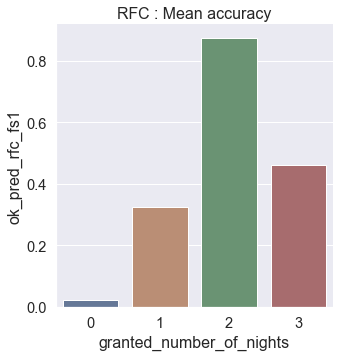

In [605]:
g = sns.catplot(x="granted_number_of_nights", y="ok_pred_rfc_fs1", 
                data=df_test, saturation=.5,
                kind="bar", ci=None)
fig = plt.gcf()
ax = plt.gca()
ax.set_title("RFC : Mean accuracy");

##### Cross validation

In [581]:
rfc_fs1_cv = RandomForestClassifier(random_state=0, n_jobs=-1,
                                    class_weight=class_weight)

In [582]:
max_features_ideal = int(np.sqrt(X_train_n.shape[1]))
n_estimators_range = [50, 100, 200]
max_depth_range = [25]
max_features_range = [max_features_ideal]
min_samples_split_range = [200, 250, 500]

score = make_scorer(competition_scorer, greater_is_better=False, 
                   needs_proba=True)
#score = 'accuracy'
# grille de paramètres
param_grid = {'n_estimators': n_estimators_range, 
              'max_features': max_features_range,
              'min_samples_split': min_samples_split_range,
              'max_depth': max_depth_range}
param_grid

{'n_estimators': [50, 100, 200],
 'max_features': [8],
 'min_samples_split': [200, 250, 500],
 'max_depth': [25]}

In [583]:
# Cross validation for hyperparameters
# 0.966 {'max_depth': 25, 'max_features': 8, 'min_samples_split': 5, 'n_estimators': 200}
g_rfc_fs1_cv = model_selection.GridSearchCV(rfc_fs1_cv,
    param_grid,  
    cv=cv,
    scoring=score,
    n_jobs=-1) 

# Optimize
t_0 = time.time()
g_rfc_fs1_cv.fit(X_train_n, y_train)
t_1 = time.time()
print("timing total: {} s".format(t_1-t_0))
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print (g_rfc_fs1_cv.best_params_)

timing total: 822.8940482139587 s
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'max_depth': 25, 'max_features': 8, 'min_samples_split': 250, 'n_estimators': 200}


In [584]:
df_res_rfc_fs1_cv = pd.DataFrame(data=g_rfc_fs1_cv.cv_results_)
df_res_rfc_fs1_cv.sort_values(by="rank_test_score").T

,5,4,2,3,1,8,7,6,0
mean_fit_time,197.126,94.3023,177.49,47.7154,90.7202,138.347,94.287,52.1498,55.6249
std_fit_time,1.41931,0.999062,0.7624,0.68549,4.21957,13.8074,0.664705,1.4459,0.323494
mean_score_time,4.32952,2.39635,4.21304,0.970786,1.90837,2.059,1.84862,0.981896,0.878904
std_score_time,0.315133,0.453551,0.154043,0.127353,0.113792,0.69806,0.0165561,0.0964461,0.0968959
param_max_depth,25,25,25,25,25,25,25,25,25
param_max_features,8,8,8,8,8,8,8,8,8
param_min_samples_split,250,250,200,250,200,500,500,500,200
param_n_estimators,200,100,200,50,100,200,100,50,50
params,"{'max_depth': 25, 'max_features': 8, 'min_samp...","{'max_depth': 25, 'max_features': 8, 'min_samp...","{'max_depth': 25, 'max_features': 8, 'min_samp...","{'max_depth': 25, 'max_features': 8, 'min_samp...","{'max_depth': 25, 'max_features': 8, 'min_samp...","{'max_depth': 25, 'max_features': 8, 'min_samp...","{'max_depth': 25, 'max_features': 8, 'min_samp...","{'max_depth': 25, 'max_features': 8, 'min_samp...","{'max_depth': 25, 'max_features': 8, 'min_samp..."
split0_test_score,-0.811574,-0.812557,-0.812893,-0.815255,-0.815135,-0.814024,-0.81555,-0.819731,-0.818696


In [610]:
print("Train accuracy :", 
      g_rfc_fs1_cv.best_estimator_.score(X_train_n, y_train))
print("Test accuracy : ",
      g_rfc_fs1_cv.best_estimator_.score(X_test_n, y_test))

prob_Y_test = g_rfc_fs1_cv.best_estimator_.predict_proba(X_test_n)
test_score = competition_scorer(y_test, prob_Y_test)
print(f'Test score : {test_score}')

Train accuracy : 0.2594682418731186
Test accuracy :  0.2519648015046685
Test score : 0.8060991421927288


In [586]:
log_loss(y_test, prob_Y_test)

1.9825570064586473

In [587]:
y_test_pred = g_rfc_fs1_cv.best_estimator_.predict(X_test_n)
df_test["y_test_pred_g_rfc_fs1"] = y_test_pred
df_test["ok_pred_g_rfc_fs1"] = df_test["y_test_pred_g_rfc_fs1"] \
    == df_test["granted_number_of_nights"]

#def fun_mean_ok(serie_in, nb_samples):

pt_count_g_rfc_fs1 = pd.pivot_table(df_test, 
                              values=['ok_pred_g_rfc_fs1'], 
               index=['granted_number_of_nights'], aggfunc=["count","mean"])
pt_count_g_rfc_fs1

,count,mean
,ok_pred_g_rfc_fs1,ok_pred_g_rfc_fs1
granted_number_of_nights,,
0,29201,0.016301
1,20478,0.302569
2,9245,0.868686
3,624,0.482372


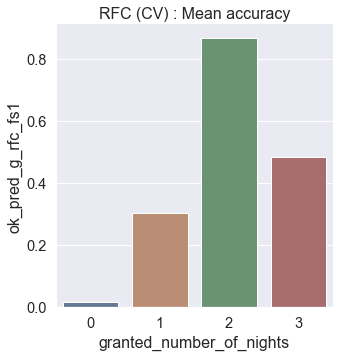

In [606]:
g = sns.catplot(x="granted_number_of_nights", y="ok_pred_g_rfc_fs1", 
                data=df_test, saturation=.5,
                kind="bar", ci=None)
fig = plt.gcf()
ax = plt.gca()
ax.set_title("RFC (CV) : Mean accuracy");

(<matplotlib.axes._subplots.AxesSubplot at 0x1a67812bd0>,
 <Figure size 1080x612 with 1 Axes>)

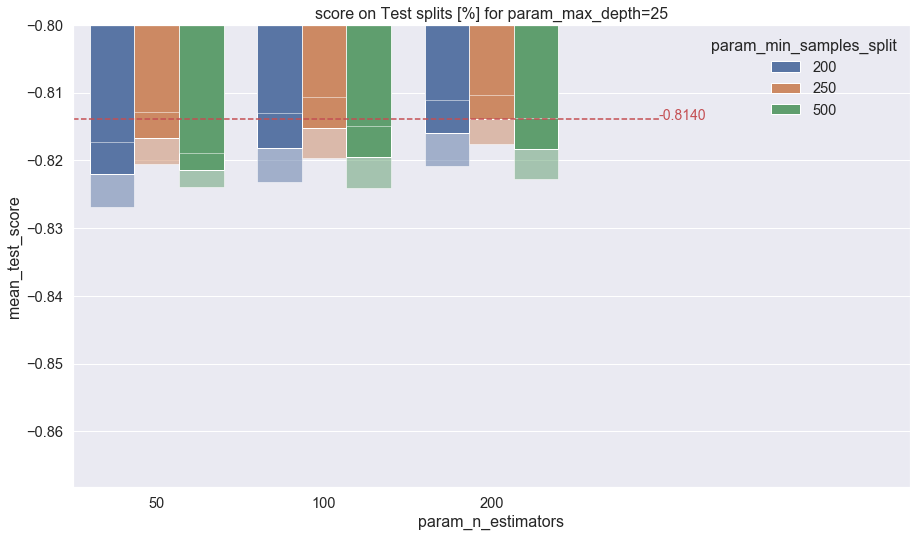

In [589]:
plot_res_test_split(df_res_rfc_fs1_cv, "score", "param_n_estimators", 
                    "param_min_samples_split",
                    y_min=-0.8, 
                    myFixedParam="param_max_depth",
                    myFixedValue=25)

=> OK : best score is 0.814 with error margin +/- 0.05

For min_sample_split=250 and n_estimators=200

We can increase n_estimators but model will be very big and slow.


##### Save model

In [659]:
dump(g_rfc_fs1_cv.best_estimator_,
     PATH_DATA + '/rfc_fs1_cv.joblib', compress=3) 

['data/rfc_fs1_cv.joblib']

In [666]:
df_res_rfc_fs1_cv.to_csv(path_or_buf=PATH_DATA + '/df_res_rfc_fs1_cv.csv', 
                         index=False)

##### add score

In [665]:
dict_scores = {"test_score": test_score,
    "test_mean_acc_0": pt_count_g_rfc_fs1.loc[0, ('mean','ok_pred_g_rfc_fs1')],
    "test_mean_acc_1": pt_count_g_rfc_fs1.loc[1, ('mean','ok_pred_g_rfc_fs1')],
    "test_mean_acc_2": pt_count_g_rfc_fs1.loc[2, ('mean','ok_pred_g_rfc_fs1')],
    "test_mean_acc_3": pt_count_g_rfc_fs1.loc[3, ('mean','ok_pred_g_rfc_fs1')],
                }

df_results = add_score(df_results, pd.Series(data = dict_scores), 'rfc_fs1_cv')
df_results

create df_results


,test_score,test_mean_acc_0,test_mean_acc_1,test_mean_acc_2,test_mean_acc_3
rfc_fs1_cv,0.806099,0.016301,0.302569,0.868686,0.482372


In [667]:
df_results.to_csv(path_or_buf=PATH_DATA + '/df_results.csv', 
                         index=False)

#### GradientBoosting

In [668]:
gbc_fs1 = GradientBoostingClassifier(random_state=0, n_estimators=20,
                                    max_depth=10) # 0.814 t=144s <-OK
# fitting
t_0 = time.time()
gbc_fs1.fit(X_train_n, y_train, sample_weight=10**y_train)
t_1 = time.time()
print(gbc_fs1)
print("timing total: {} s".format(t_1-t_0))

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=10,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=20,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
timing total: 160.99999690055847 s


In [669]:
print("Train acc : ", 
      gbc_fs1.score(X_train_n, y_train))
print("Test acc : ",
      gbc_fs1.score(X_test_n, y_test))

prob_Y_test = gbc_fs1.predict_proba(X_test_n)
gbc_fs1_score = competition_scorer(y_test, prob_Y_test)
print(f'Test score : {gbc_fs1_score}')

Train acc :  0.34865717008619135
Test acc :  0.33169879760865184
Test score : 0.814464931401777


In [670]:
y_test_pred = gbc_fs1.predict(X_test_n)
print("Mean accuracy: ")
accuracy_score(y_test, y_test_pred)

Mean accuracy: 


0.33169879760865184

In [671]:
# add prediction into database
df_test["y_test_pred_gbc_fs1"] = y_test_pred

df_test["ok_pred_gbc_fs1"] = df_test["y_test_pred_gbc_fs1"] \
    == df_test["granted_number_of_nights"]

# pivot table to calculate mean accuracy by classes
pt_count_gbc_fs1 = pd.pivot_table(df_test, 
                              values=['ok_pred_gbc_fs1'], 
               index=['granted_number_of_nights'], aggfunc=["count", np.mean])
pt_count_gbc_fs1

,count,mean
,ok_pred_gbc_fs1,ok_pred_gbc_fs1
granted_number_of_nights,,
0,29201,0.153282
1,20478,0.350669
2,9245,0.841644
3,624,0.503205


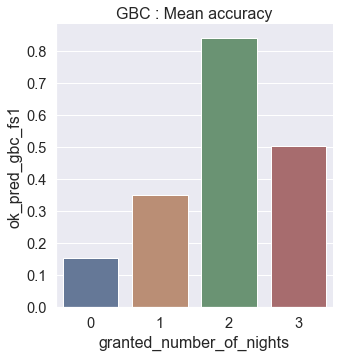

In [672]:
g = sns.catplot(x="granted_number_of_nights", y="ok_pred_gbc_fs1", 
                data=df_test, saturation=.5,
                kind="bar", ci=None)
fig = plt.gcf()
ax = plt.gca()
ax.set_title("GBC : Mean accuracy");

##### Cross validation

We optimize hyper-parameters to improve competition score.

We have tried to improve with learning_rate and max_depth but we haven't found a big improvement.

So we use : learning_rate=0.1 & max_depth=10

And try to improve with n_estimators & min_samples_split: 

In [737]:
gbc_fs1_cv = GradientBoostingClassifier(random_state=0)

In [738]:
n_estimators_range = [20, 40, 60]
max_depth_range = [10]
min_samples_split_range = [1000, 2000, 3000]
score = make_scorer(competition_scorer, greater_is_better=False, 
                   needs_proba=True)

# parameter grid
param_grid = {'n_estimators': n_estimators_range, 
              'min_samples_split': min_samples_split_range,
              'max_depth': max_depth_range}
param_grid

{'n_estimators': [20, 40, 60],
 'min_samples_split': [1000, 2000, 3000],
 'max_depth': [10]}

In [739]:
#0.788 {'max_depth': 10, 'min_samples_split': 2000, 'n_estimators': 60}
#Cross validation for hyperparameters
g_gbc_fs1_cv = model_selection.GridSearchCV(gbc_fs1_cv,
    param_grid,  
    cv=cv,
    scoring=score,
    n_jobs=-1) 

# Optimize
t_0 = time.time()
g_gbc_fs1_cv.fit(X_train_n, y_train, sample_weight=10**y_train)
t_1 = time.time()
print("timing total: {} s".format(t_1-t_0))
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print (g_gbc_fs1_cv.best_params_)

timing total: 6077.3616671562195 s
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'max_depth': 10, 'min_samples_split': 2000, 'n_estimators': 60}


In [740]:
df_res_gbc_fs1_cv = pd.DataFrame(data=g_gbc_fs1_cv.cv_results_)
df_res_gbc_fs1_cv.sort_values(by="rank_test_score").T

,5,4,8,1,7,2,0,3,6
mean_fit_time,1267.43,814.95,935.267,818.013,808.857,1266.18,404.467,398.48,395.187
std_fit_time,9.13731,5.50088,156.793,2.51293,5.08733,6.20512,2.58536,1.60191,4.06684
mean_score_time,1.7306,1.23722,1.04261,1.2583,1.17623,1.75895,0.811124,0.708321,0.666728
std_score_time,0.0592847,0.0344746,0.197547,0.0202408,0.0301024,0.0745506,0.0435972,0.0144549,0.0196244
param_max_depth,10,10,10,10,10,10,10,10,10
param_min_samples_split,2000,2000,3000,1000,3000,1000,1000,2000,3000
param_n_estimators,60,40,60,40,40,60,20,20,20
params,"{'max_depth': 10, 'min_samples_split': 2000, '...","{'max_depth': 10, 'min_samples_split': 2000, '...","{'max_depth': 10, 'min_samples_split': 3000, '...","{'max_depth': 10, 'min_samples_split': 1000, '...","{'max_depth': 10, 'min_samples_split': 3000, '...","{'max_depth': 10, 'min_samples_split': 1000, '...","{'max_depth': 10, 'min_samples_split': 1000, '...","{'max_depth': 10, 'min_samples_split': 2000, '...","{'max_depth': 10, 'min_samples_split': 3000, '..."
split0_test_score,-0.786816,-0.78562,-0.783646,-0.789234,-0.787779,-0.794319,-0.804186,-0.805836,-0.812306
split1_test_score,-0.791798,-0.793026,-0.793371,-0.793627,-0.796553,-0.794983,-0.80754,-0.813495,-0.817207


Plot of hyperparameters impacts : 

(<matplotlib.axes._subplots.AxesSubplot at 0x1a45530c90>,
 <Figure size 1080x612 with 1 Axes>)

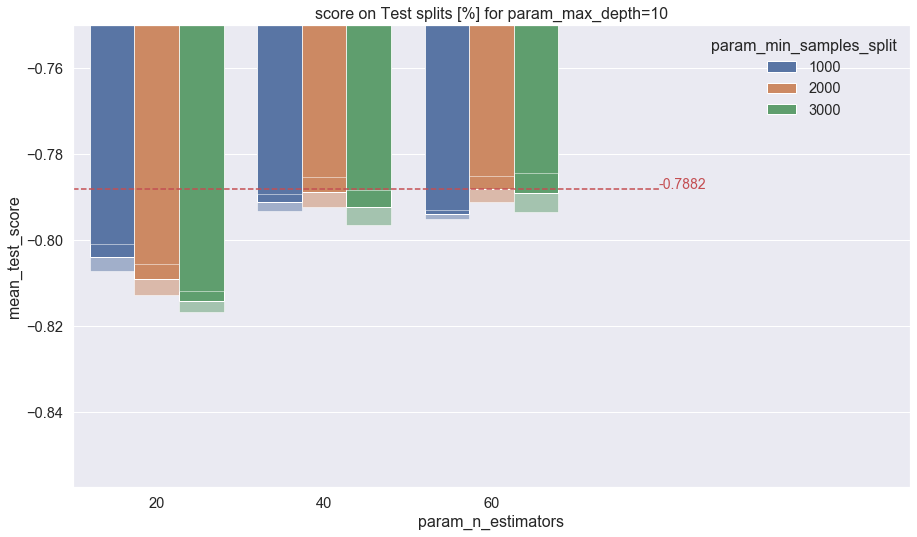

In [741]:
plot_res_test_split(df_res_gbc_fs1_cv, "score", "param_n_estimators", 
                    "param_min_samples_split",
                    y_min=-0.75, 
                    myFixedParam="param_max_depth",
                    myFixedValue=10)

=> Hyper-parameters study : 
- Improvement with more n_estimators. n_estimators > 60 might improve a little but training time will  increase a lot. 
- Also, min_samples_split around 2000 is better.

Scores : 

In [742]:
print("Train mean accuracy :", 
      g_gbc_fs1_cv.best_estimator_.score(X_train_n, y_train))
print("Test mean accuracy : ",
      g_gbc_fs1_cv.best_estimator_.score(X_test_n, y_test))

prob_Y_test = g_gbc_fs1_cv.best_estimator_.predict_proba(X_test_n)

test_score = competition_scorer(y_test, prob_Y_test)
print(f'Test score : {test_score}')

Train mean accuracy : 0.32809384065728764
Test mean accuracy :  0.31989319540538724
Test score : 0.7875099217015011


=> OK : Test score is < 1

In [743]:
# predict Test
y_test_pred = g_gbc_fs1_cv.best_estimator_.predict(X_test_n)

# add data
df_test["y_test_pred_g_gbc_fs1"] = y_test_pred
df_test["ok_pred_g_gbc_fs1"] = df_test["y_test_pred_g_gbc_fs1"] \
    == df_test["granted_number_of_nights"]

# table of mean accuracy by classes
pt_count_g_gbc_fs1 = pd.pivot_table(df_test, 
                              values=['ok_pred_g_gbc_fs1'], 
               index=['granted_number_of_nights'], aggfunc=["count","mean"])
pt_count_g_gbc_fs1

,count,mean
,ok_pred_g_gbc_fs1,ok_pred_g_gbc_fs1
granted_number_of_nights,,
0,29201,0.116469
1,20478,0.377527
2,9245,0.817847
3,624,0.570513


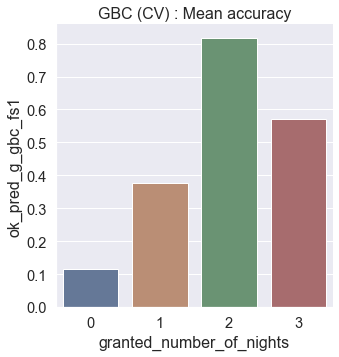

In [744]:
g = sns.catplot(x="granted_number_of_nights", y="ok_pred_g_gbc_fs1", 
                data=df_test, saturation=.5,
                kind="bar", ci=None)

fig = plt.gcf()
ax = plt.gca()
ax.set_title("GBC (CV) : Mean accuracy");

##### Save model

In [745]:
dump(g_gbc_fs1_cv.best_estimator_,
     PATH_DATA + '/gbc_fs1_cv.joblib', compress=3) 

['data/gbc_fs1_cv.joblib']

In [746]:
df_res_gbc_fs1_cv.to_csv(path_or_buf=PATH_DATA + '/df_res_gbc_fs1_cv.csv', 
                         index=False)

##### add score

In [747]:
dict_scores = {"test_score": test_score,
    "test_mean_acc_0": pt_count_g_gbc_fs1.loc[0, ('mean','ok_pred_g_gbc_fs1')],
    "test_mean_acc_1": pt_count_g_gbc_fs1.loc[1, ('mean','ok_pred_g_gbc_fs1')],
    "test_mean_acc_2": pt_count_g_gbc_fs1.loc[2, ('mean','ok_pred_g_gbc_fs1')],
    "test_mean_acc_3": pt_count_g_gbc_fs1.loc[3, ('mean','ok_pred_g_gbc_fs1')],
                }

df_results = add_score(df_results, pd.Series(data = dict_scores), 'gbc_fs1_cv')
df_results

update line


,test_score,test_mean_acc_0,test_mean_acc_1,test_mean_acc_2,test_mean_acc_3,model
rfc_fs1_cv,0.806099,0.016301,0.302569,0.868686,0.482372,rfc_fs1_cv
gbc_fs1_cv,0.787510,0.116469,0.377527,0.817847,0.570513,NaN


### Comprare & Conclusion

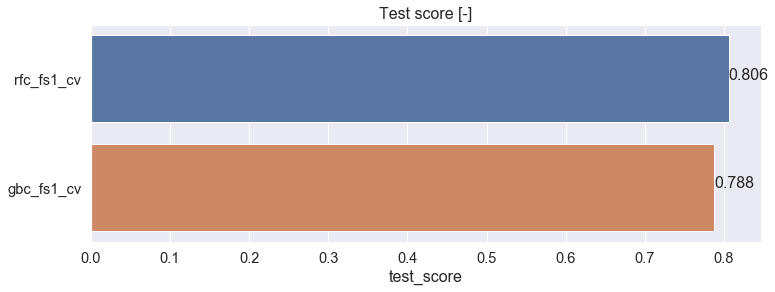

In [748]:
fig = plt.figure(figsize=(12, 4))
plt.title("Test score [-]")
ax = sns.barplot(
    y=df_results.index,
    x=df_results["test_score"], orient="h")

for I, index in enumerate(df_results.index):
    plt.text(x=df_results.at[index,"test_score"], y=I,
      s= '{:.3f}'.format(df_results.at[index,"test_score"]), 
           fontsize=16)

=> Test competition scores are  < 1 and they are close together.


In [749]:
df_results

,test_score,test_mean_acc_0,test_mean_acc_1,test_mean_acc_2,test_mean_acc_3,model
rfc_fs1_cv,0.806099,0.016301,0.302569,0.868686,0.482372,rfc_fs1_cv
gbc_fs1_cv,0.787510,0.116469,0.377527,0.817847,0.570513,NaN


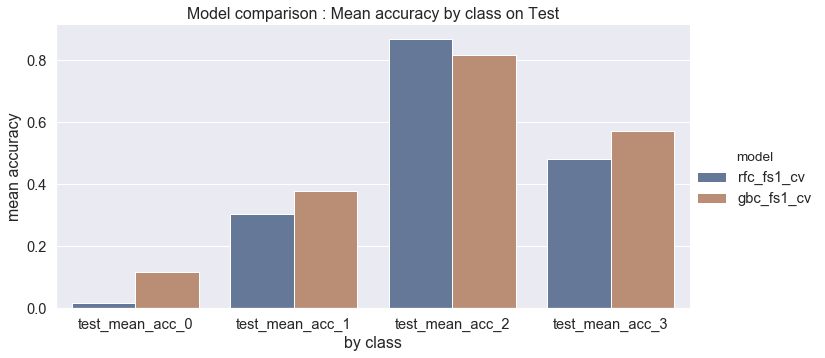

In [750]:
df_results["model"] = df_results.index

df_plot = df_results.melt(id_vars=['model'], value_vars=['test_mean_acc_0', 
                                                'test_mean_acc_1', 
                                                'test_mean_acc_2', 
                                                'test_mean_acc_3'])

df_plot.columns = ["model", "by class", "mean accuracy"]
g = sns.catplot(x="by class", y="mean accuracy", hue="model",
                data=df_plot, saturation=.5,
                kind="bar", ci=None, height=5, aspect=2)
fig = plt.gcf()
ax = plt.gca()
ax.set_title("Model comparison : Mean accuracy by class on Test");

=> Gradient Boost model is more balanced between classes. 

If we have to choose, maybe Gradient Boost have more potential to achieve the requested task.

But Random Forest is quicker than Gradient Boost with their best hyper-parameters : 
- Random Forest = 18s to train
- Gradient Boosting : 400s to train

(prediction timing are close and fast < 1s)